In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations, permutations
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

import hmms
import os
import math

In [2]:
# Configuration parameters
N_nodes = 81
random_state = 2
# rejection_negative_bias = 2
# pbl_negative_bias = 0
# pbr_negative_bias = 2
# rotl_negative_bias = 4
# rotr_negative_bias = 3
# pc_negative_bias = 0
rejection_negative_bias = 0
pbl_negative_bias = 0
pbr_negative_bias = 0
rotl_negative_bias = 0
rotr_negative_bias = 0
pc_negative_bias = 0

rejections_trained = True
# baum_welch = True
# bw_epochs = 10

# Observation matrix params
prob_emission_equals_hidden = 0.95

prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden

#Trans prob matrix params
trans_prob_factor = 100
rejection_trans_prob_factor = 1

#Init prob matrix params
init_prob_factor = 100
rejection_init_prob_factor = 1

## Load training QTC_C sequences (experimenter interacting in lab)

In [3]:
rotl_lab_seqs = []
rotr_lab_seqs = []
pb_l_lab_seqs = []
pb_r_lab_seqs = []
pc_lab_seqs = []
u_lab_seqs = []
u_lab_seqs_no_train = []

with open("lab_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

{'u_h_meets_stationary_r_3': ['----', '---0', '-+-+'],
 'ot_hotr_12': ['+-0+',
  '+--+',
  '+0-+',
  '0+-+',
  '-+-+',
  '---+',
  '-0-+',
  '---0'],
 'u_h_pb_l_robot_stationary_6': ['---+',
  '-00+',
  '--0+',
  '-0++',
  '--++',
  '00++',
  '++++'],
 'u_h_pb_l_robot_stationary_8': ['---+',
  '--0+',
  '--++',
  '-+++',
  '--++',
  '+-++',
  '++++'],
 'ot_hotl_6': ['+-+-',
  '0++-',
  '-++-',
  '-+0-',
  '-+--',
  '-+-+',
  '----',
  '-0--',
  '----',
  '++--',
  '+--+'],
 'u_h_and_r_stationary_6': ['+--+'],
 'u_h_pb_l_robot_stationary_7': ['---+',
  '--0+',
  '--++',
  '--+-',
  '--++',
  '0+++',
  '++++'],
 'u_h_meets_stationary_r_5': ['---+',
  '---0',
  '----',
  '---0',
  '----',
  '---0',
  '---+',
  '-+-+',
  '-+-0',
  '-+-+'],
 'u_r_meets_stationary_h_3': ['---+', '---0', '----', '---0'],
 'ot_rotl_33': ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '-0-+',
  '---+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '-0-+',
  '---+',
  '-0-+',
  '---+',
  '00-+

In [4]:
for key in lab_seqs.keys():
    if key.split("_")[0] == "u":
        print(key)

u_h_meets_stationary_r_3
u_h_pb_l_robot_stationary_6
u_h_pb_l_robot_stationary_8
u_h_and_r_stationary_6
u_h_pb_l_robot_stationary_7
u_h_meets_stationary_r_5
u_r_meets_stationary_h_3
u_r_meets_stationary_h_13
u_h_pb_r_robot_stationary_1
u_h_pb_r_robot_stationary_2
u_h_pb_r_robot_stationary_3
u_h_pb_r_robot_stationary_6
u_h_pb_r_robot_stationary_7
u_h_pb_r_robot_stationary_4
u_h_pb_r_robot_stationary_5
u_r_meets_stationary_h_12
u_h_and_r_stationary_10
u_h_and_r_stationary_12
u_h_pb_r_robot_stationary_8
u_h_meets_stationary_r_12
u_h_meets_stationary_r_13
u_h_meets_stationary_r_10
u_h_meets_stationary_r_11
u_h_meets_stationary_r_14
u_h_meets_stationary_r_15
u_h_and_r_stationary_9
u_h_meets_stationary_r_6
u_h_meets_stationary_r_7
u_h_pb_l_robot_stationary_12
u_h_and_r_stationary_8
u_r_meets_stationary_h_10
u_h_meets_stationary_r_4
u_r_meets_stationary_h_2
u_h_pb_l_robot_stationary_15
u_h_and_r_stationary_7
u_h_pb_l_robot_stationary_13
u_h_pb_r_robot_stationary_9
u_h_pb_r_robot_stationary_14

In [5]:
for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[1] == "rotl":
        rotl_lab_seqs.append(lab_seqs[key])
    elif key.split("_")[1] == "rotr":
        rotr_lab_seqs.append(lab_seqs[key])
    elif class_code == "pb":
        if key.split("_")[1] == "l":
            pb_l_lab_seqs.append(lab_seqs[key])
        else:
            pb_r_lab_seqs.append(lab_seqs[key])
    elif class_code == "pc":
        pc_lab_seqs.append(lab_seqs[key])
#     elif "u_r_meets" in key or "u_h_meets" in key:
#         u_lab_seqs_no_train.append(lab_seqs[key])
    else:
        u_lab_seqs.append(lab_seqs[key])
        
print(len(rotl_lab_seqs))
print(len(rotr_lab_seqs))
print(len(pb_l_lab_seqs))
print(len(pb_r_lab_seqs))
print(len(pc_lab_seqs))
print(len(u_lab_seqs))
print(len(u_lab_seqs_no_train))

35
35
35
35
70
105
0


## Load test QTC_C sequences (participants interacting in lab study)

In [6]:
rotl_study_seqs = []
rotr_study_seqs = []
pb_l_study_seqs = []
pb_r_study_seqs = []
pc_study_seqs = []
u_study_seqs = []
u_study_seqs_no_train = []

with open("study_qtc_seqs.pickle", "rb") as f:
    study_seqs = pickle.load(f)
study_seqs

{'pcr_4': ['---+', '-+-+', '---+', '-+-+', '-+0+', '-+++', '--++'],
 'rotl_10': ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+'],
 'rotl_11': ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0-+',
  '---+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0--',
  '00--',
  '00-0',
  '00-+',
  '0--+',
  '0--0',
  '00-0',
  '0+--',
  '+0-0',
  '+0--',
  '+0-0',
  '+--0',
  '+--+',
  '+--0',
  '+--+',
  '+0-+',
  '+--+',
  '+0-+',
  '+--+'],
 'rotl_12': ['-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+',
  '00-+'],
 'pbl_10': ['----', '0---', '+---', '+0--', '++--', '++0-', '+++-', '+-+-'],
 'pbl_11': ['----',
  '0---',
  '+0--',
  '++--',
  '++0-',
  '+-0-',
  '+-+-',
  '+-++',
  '+-+0',
  '+-++',
  '+-0+'],
 'pbl_12': ['---+',
  '---0',
  '----',
  '---0',
  '----',
  '+---',
  '++--',
  '++0-',
  '+++-'],
 'pcr_1': ['0--+', '---+', '-0-+', '-

In [7]:
len(study_seqs)

75

In [8]:
for key in study_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[0] == "rotl":
        rotl_study_seqs.append(study_seqs[key])
    elif key.split("_")[0] == "rotr":
        rotr_study_seqs.append(study_seqs[key])
    elif "pb" in class_code:
        if "l" in class_code:
            pb_l_study_seqs.append(study_seqs[key])
        else:
            pb_r_study_seqs.append(study_seqs[key])
    elif "pc" in class_code:
        pc_study_seqs.append(study_seqs[key])
    else:
        u_study_seqs.append(study_seqs[key])
        
print(len(rotl_study_seqs))
print(len(rotr_study_seqs))
print(len(pb_l_study_seqs))
print(len(pb_r_study_seqs))
print(len(pc_study_seqs))
print(len(u_study_seqs))

11
10
11
11
21
11


In [9]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [10]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [11]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [12]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by left HMM

In [13]:
pass_by_l_seqs = pb_l_study_seqs

In [14]:
pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
print(pass_by_l_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

[[40, 67, 13, 22, 4, 7, 1, 10], [40, 67, 22, 4, 7, 16, 10, 9, 11, 9, 15], [39, 41, 40, 41, 40, 13, 4, 7, 1], [41, 40, 67, 13, 22, 4, 7, 1], [40, 67, 22, 4, 7, 10], [41, 40, 67, 13, 22, 4, 7, 1, 10], [40, 67, 13, 22, 4, 7], [40, 67, 13, 4, 7], [48, 39, 31, 66, 77, 75, 66, 58, 66, 75, 66, 75, 59, 12, 3, 12], [40, 67, 13, 22, 4, 7, 1, 10, 11, 9, 11], [39, 10, 11, 9, 1, 9, 10, 1, 9, 13, 22, 4, 7, 1]]


[['----', '0---', '+---', '+0--', '++--', '++0-', '+++-', '+-+-'],
 ['----',
  '0---',
  '+0--',
  '++--',
  '++0-',
  '+-0-',
  '+-+-',
  '+-++',
  '+-+0',
  '+-++',
  '+-0+'],
 ['---+', '---0', '----', '---0', '----', '+---', '++--', '++0-', '+++-'],
 ['---0', '----', '0---', '+---', '+0--', '++--', '++0-', '+++-'],
 ['----', '0---', '+0--', '++--', '++0-', '+-+-'],
 ['---0', '----', '0---', '+---', '+0--', '++--', '++0-', '+++-', '+-+-'],
 ['----', '0---', '+---', '+0--', '++--', '++0-'],
 ['----', '0---', '+---', '++--', '++0-'],
 ['-0-+',
  '---+',
  '-+--',
  '0--+',
  '00-0',
  '00-+',
  '0--+',
  '0+--',
  '0--+',
  '00-+',
  '0--+',
  '00-+',
  '0+-0',
  '+--+',
  '++-+',
  '+--+'],
 ['----',
  '0---',
  '+---',
  '+0--',
  '++--',
  '++0-',
  '+++-',
  '+-+-',
  '+-+0',
  '+-++',
  '+-+0'],
 ['---+',
  '+-+-',
  '+-+0',
  '+-++',
  '+++-',
  '+-++',
  '+-+-',
  '+++-',
  '+-++',
  '+---',
  '+0--',
  '++--',
  '++0-',
  '+++-']]

In [15]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_l_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
0
1
2
3
4
0
1
2
3
4
5
6
7
0
1
2
3
4
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00172117 0.00172117 0.00172117 ... 0.00172117 0.00172117 0.00172117]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [16]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_l_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pblHMM = hmms.DtHMM(A, B, Pi)

# Check pblHMM params
A, B, Pi = pblHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.00172117 0.00172117 0.00172117 ... 0.00172117 0.00172117 0.00172117]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [17]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Left_Lab_Egs_Transitions", 0.013)

Pass-by left HMM:


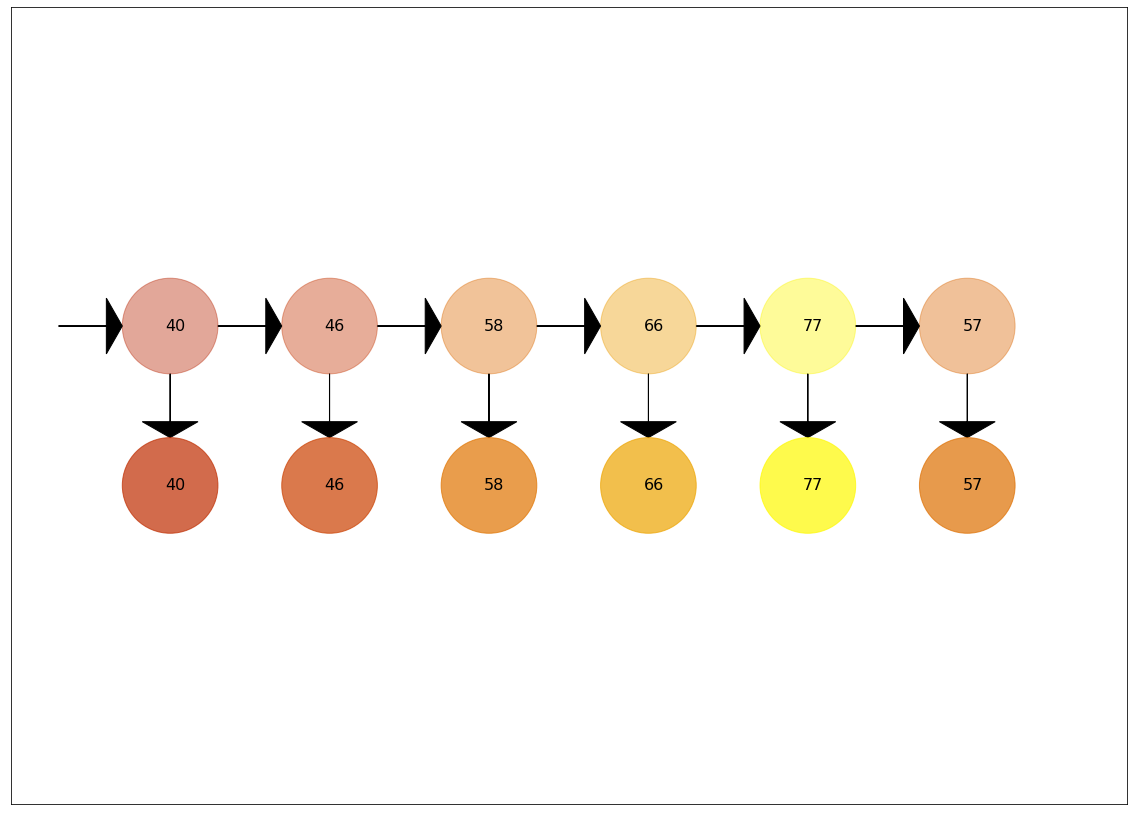

['----', '-0+-', '0+--', '0--+', '00-0', '0+-+']


In [18]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pblHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating pass-by right HMM

In [19]:
pass_by_r_seqs = pb_r_study_seqs

In [20]:
pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
print(pass_by_r_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

[[39, 42, 36, 45, 36, 0], [39, 42, 36, 27, 36, 54, 0, 10, 64, 37, 46], [39, 42, 36, 63, 0, 9, 10, 1], [39, 42, 36, 45, 36, 54, 0], [39, 42, 36, 27, 36, 0, 2], [39, 42, 36, 63, 9, 18, 9, 0, 9, 0, 1], [39, 42, 36, 0, 10], [39, 42, 36, 63, 9, 0], [39, 42, 36, 27, 36, 0], [39, 42, 36, 27, 54, 0], [39, 42, 36, 54, 0]]


[['---+', '--0+', '--++', '-0++', '--++', '++++'],
 ['---+',
  '--0+',
  '--++',
  '-+++',
  '--++',
  '0+++',
  '++++',
  '+-+-',
  '0-+-',
  '--+-',
  '-0+-'],
 ['---+', '--0+', '--++', '0-++', '++++', '+-++', '+-+-', '+++-'],
 ['---+', '--0+', '--++', '-0++', '--++', '0+++', '++++'],
 ['---+', '--0+', '--++', '-+++', '--++', '++++', '+++0'],
 ['---+',
  '--0+',
  '--++',
  '0-++',
  '+-++',
  '+0++',
  '+-++',
  '++++',
  '+-++',
  '++++',
  '+++-'],
 ['---+', '--0+', '--++', '++++', '+-+-'],
 ['---+', '--0+', '--++', '0-++', '+-++', '++++'],
 ['---+', '--0+', '--++', '-+++', '--++', '++++'],
 ['---+', '--0+', '--++', '-+++', '0+++', '++++'],
 ['---+', '--0+', '--++', '0+++', '++++']]

In [21]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_r_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
9
0
1
2
3
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.00146843 0.14831131 0.14831131 ... 0.00146843 0.00146843 0.00146843]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [22]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_r_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbrHMM = hmms.DtHMM(A, B, Pi)

# Check pbrHMM params
A, B, Pi = pbrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.00146843 0.14831131 0.14831131 ... 0.00146843 0.00146843 0.00146843]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [23]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Right_Lab_Egs_Transitions", 0.013)

Pass-by right HMM:


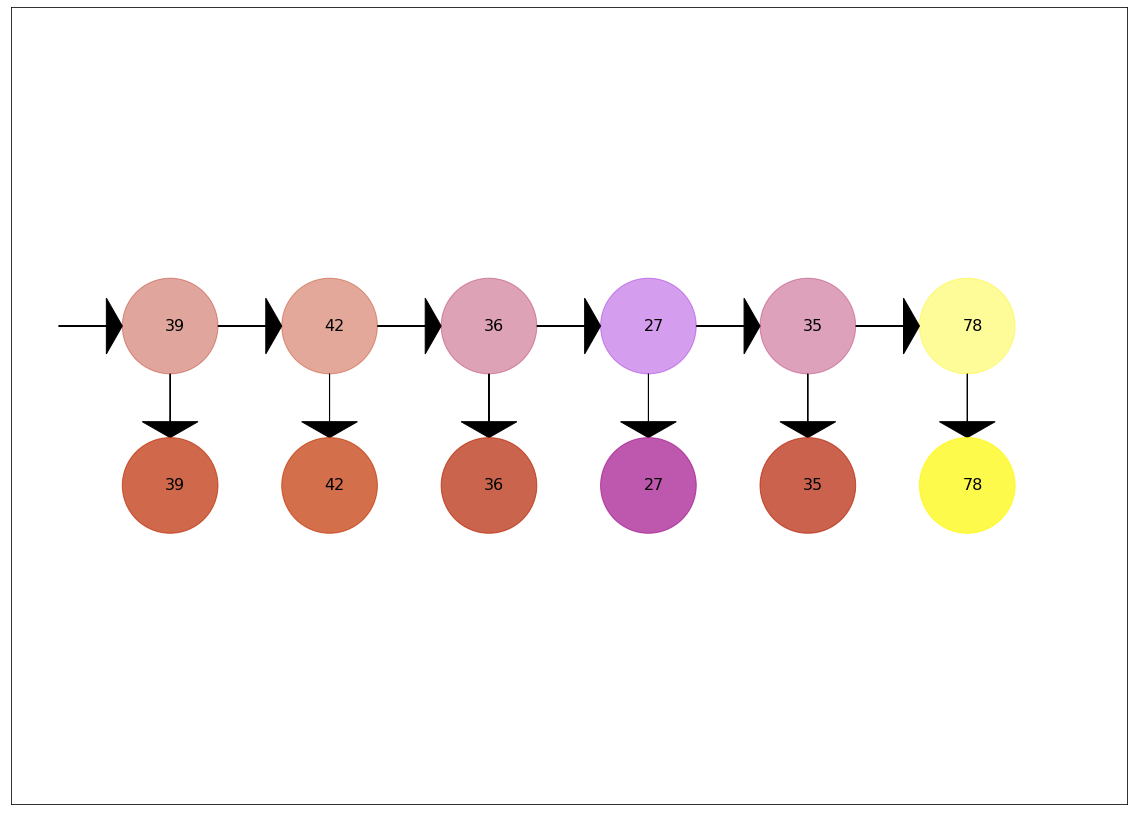

['---+', '--0+', '--++', '-+++', '-+00', '000+']


In [24]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating robot overtakes left HMM

In [25]:
rotl_seqs = rotl_study_seqs

In [26]:
rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
print(rotl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

[[30, 48, 30, 48, 30, 48, 30, 48, 75, 66], [30, 48, 30, 48, 39, 41, 50, 48, 39, 48, 30, 48, 39, 41, 50, 49, 76, 77, 75, 66, 68, 77, 58, 23, 22, 23, 14, 12, 14, 12, 21, 12, 21, 12], [48, 30, 48, 30, 48, 30, 48, 30, 48, 75, 66, 75], [30, 48, 30, 48, 30, 48, 30, 48, 30, 48, 30, 39, 48, 75, 66, 75], [30, 48, 30, 48, 30, 48, 30, 48, 30, 48, 30, 48, 30, 39, 48, 30, 48, 57, 75], [30, 48, 30, 48, 30, 48, 30, 48, 39], [30, 48, 39, 48, 30, 48, 50, 48, 39, 48, 39, 48, 30, 57, 75, 66, 68, 14, 12, 14, 21, 12], [48, 30, 48, 39, 48, 30, 48, 30, 39, 40, 30, 75, 77, 75, 66, 75, 21, 12], [30, 48, 30, 48, 30, 48, 39, 30, 41, 40, 48], [30, 48, 30, 48, 39, 48, 30, 48, 30, 48, 39, 48, 39, 48, 75, 66, 75], [30, 50, 32, 30, 48, 30, 48, 30, 31, 58, 4, 14, 12, 4, 13, 12, 31, 66, 39, 48, 30, 48, 39, 48, 75, 57, 75, 66]]


[['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+'],
 ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0-+',
  '---+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0--',
  '00--',
  '00-0',
  '00-+',
  '0--+',
  '0--0',
  '00-0',
  '0+--',
  '+0-0',
  '+0--',
  '+0-0',
  '+--0',
  '+--+',
  '+--0',
  '+--+',
  '+0-+',
  '+--+',
  '+0-+',
  '+--+'],
 ['-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+',
  '00-+'],
 ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '---+',
  '-0-+',
  '00-+',
  '0--+',
  '00-+'],
 ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '---+',
  '-0-+',
  '-+-+',
  '-0-+',
  '0+-+',
  '00-+'],
 ['-+-+', '-0-+', '-+-+', '-0-+', '-+-+', '-0-+', '-+-+', '-0-+', '---+'],
 ['-+-+',


In [27]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568

In [28]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotlHMM = hmms.DtHMM(A, B, Pi)

# Check rotlHMM params
A, B, Pi = rotlHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.76291279 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.17019475 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674 0.00084674
 0.00084674 0.00084674 0.00084674]
1.0
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234

In [29]:
A.min()

0.00017298045320878752

In [30]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Left_Lab_Egs_Transitions", 0.0124)

Robot overtakes left HMM:


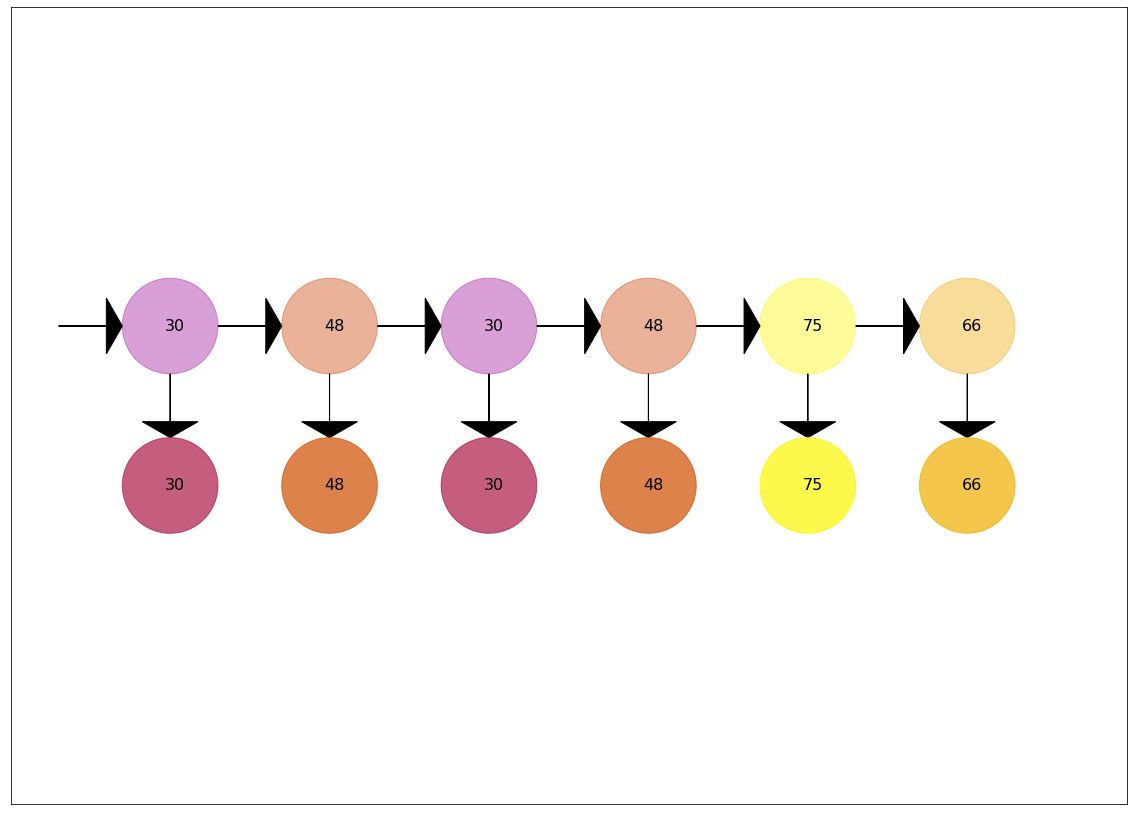

['-+-+', '-0-+', '-+-+', '-0-+', '00-+', '0--+']


In [31]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotlHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating robot overtakes right HMM

In [32]:
rotr_seqs = rotr_study_seqs

In [33]:
rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
print(rotr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

[[28, 29, 27, 29, 28, 29, 28, 29, 28], [35, 33, 35, 34, 35, 33, 35, 53, 51, 45, 27, 29, 28, 46, 47, 29, 27, 29, 28, 46, 28, 46, 28, 29, 28, 46, 28], [28, 29, 27, 29, 28, 29, 27, 28, 29, 28, 29, 28, 29, 28], [35, 33, 35, 29, 28, 34, 35, 33, 35, 27, 29, 28, 29, 47, 29, 27, 29, 28, 29, 28, 29, 28, 46, 28], [28, 29, 28, 29, 28], [28, 29, 28, 29, 28, 29, 28, 34, 35, 29, 28, 29, 27, 29, 27, 28, 29], [35, 29, 28, 34, 35, 29, 28, 29, 27, 29, 28, 29, 28, 29, 28], [35, 33, 29, 28, 29, 27, 29, 27, 29, 27, 29, 28, 29, 28, 29, 28, 29, 28], [35, 34, 35, 33, 35, 33, 27, 29, 28, 29, 27, 29, 28, 46, 28, 29, 28, 29], [35, 33, 35, 34, 35, 33, 29, 27, 29, 28, 29, 28, 29, 28, 29, 28]]


[['-++-', '-++0', '-+++', '-++0', '-++-', '-++0', '-++-', '-++0', '-++-'],
 ['-+00',
  '-+0+',
  '-+00',
  '-+0-',
  '-+00',
  '-+0+',
  '-+00',
  '-000',
  '-00+',
  '-0++',
  '-+++',
  '-++0',
  '-++-',
  '-0+-',
  '-0+0',
  '-++0',
  '-+++',
  '-++0',
  '-++-',
  '-0+-',
  '-++-',
  '-0+-',
  '-++-',
  '-++0',
  '-++-',
  '-0+-',
  '-++-'],
 ['-++-',
  '-++0',
  '-+++',
  '-++0',
  '-++-',
  '-++0',
  '-+++',
  '-++-',
  '-++0',
  '-++-',
  '-++0',
  '-++-',
  '-++0',
  '-++-'],
 ['-+00',
  '-+0+',
  '-+00',
  '-++0',
  '-++-',
  '-+0-',
  '-+00',
  '-+0+',
  '-+00',
  '-+++',
  '-++0',
  '-++-',
  '-++0',
  '-0+0',
  '-++0',
  '-+++',
  '-++0',
  '-++-',
  '-++0',
  '-++-',
  '-++0',
  '-++-',
  '-0+-',
  '-++-'],
 ['-++-', '-++0', '-++-', '-++0', '-++-'],
 ['-++-',
  '-++0',
  '-++-',
  '-++0',
  '-++-',
  '-++0',
  '-++-',
  '-+0-',
  '-+00',
  '-++0',
  '-++-',
  '-++0',
  '-+++',
  '-++0',
  '-+++',
  '-++-',
  '-++0'],
 ['-+00',
  '-++0',
  '-++-',
  '-+0-',
  '-+00',
  '-++0'

In [34]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01

In [35]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotrHMM = hmms.DtHMM(A, B, Pi)

# Check rotrHMM params
A, B, Pi = rotrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.37095282 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.5559667
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507 0.00092507
 0.00092507 0.00092507 0.00092507]
1.0
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.012345

In [36]:
A.min()

0.00018935807612194649

In [37]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Right_Lab_Egs_Transitions", 0.0124)

Robot overtakes right HMM:


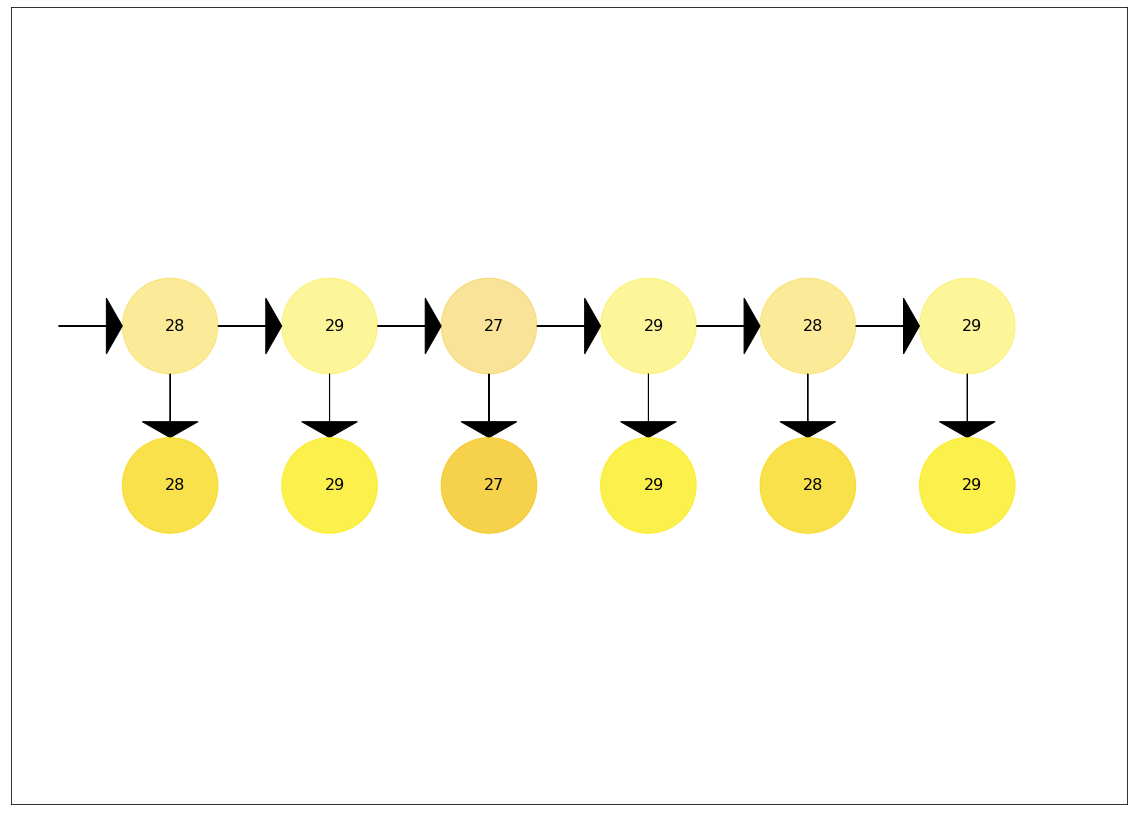

['-++-', '-++0', '-+++', '-++0', '-++-', '-++0']


In [38]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating path-crossing HMM

In [39]:
pc_seqs = pc_study_seqs

In [40]:
pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
print(pc_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

[[39, 30, 39, 30, 33, 27, 36], [66, 39, 48, 30, 33], [40, 31, 40, 31, 40, 31, 58, 4, 13, 1], [40, 49, 40, 49, 31, 58, 4, 13], [49, 40, 49, 40, 31, 40, 31, 58, 4, 5, 3, 5, 3], [40, 31, 40, 49, 40, 49, 31, 58, 4, 3], [31, 49, 31, 40, 49, 40, 49, 40, 49, 31, 58, 4, 5], [40, 31, 40, 49, 40, 31, 49, 31, 58, 4, 21, 13, 7, 9, 11], [31, 40, 49, 40, 49, 40, 49, 31, 58, 5, 4], [31, 40, 49, 31, 58, 4, 5, 3], [39, 48, 30], [66, 39, 48, 30, 33], [40, 31, 49, 40, 49, 31, 58, 4, 5], [31, 40, 49, 40, 49, 31, 58, 4], [39, 30, 33], [39, 48, 30, 33], [39, 48, 39, 30], [40, 49, 40, 49, 31, 58, 4, 3], [30, 39, 30], [66, 39, 48, 30, 33], [39, 30, 48, 30, 33, 42, 36]]


[['---+', '-+-+', '---+', '-+-+', '-+0+', '-+++', '--++'],
 ['0--+', '---+', '-0-+', '-+-+', '-+0+'],
 ['----',
  '-+--',
  '----',
  '-+--',
  '----',
  '-+--',
  '0+--',
  '++--',
  '+---',
  '+++-'],
 ['----', '-0--', '----', '-0--', '-+--', '0+--', '++--', '+---'],
 ['-0--',
  '----',
  '-0--',
  '----',
  '-+--',
  '----',
  '-+--',
  '0+--',
  '++--',
  '++-0',
  '++-+',
  '++-0',
  '++-+'],
 ['----',
  '-+--',
  '----',
  '-0--',
  '----',
  '-0--',
  '-+--',
  '0+--',
  '++--',
  '++-+'],
 ['-+--',
  '-0--',
  '-+--',
  '----',
  '-0--',
  '----',
  '-0--',
  '----',
  '-0--',
  '-+--',
  '0+--',
  '++--',
  '++-0'],
 ['----',
  '-+--',
  '----',
  '-0--',
  '----',
  '-+--',
  '-0--',
  '-+--',
  '0+--',
  '++--',
  '+0-+',
  '+---',
  '++0-',
  '+-++',
  '+-+0'],
 ['-+--',
  '----',
  '-0--',
  '----',
  '-0--',
  '----',
  '-0--',
  '-+--',
  '0+--',
  '++-0',
  '++--'],
 ['-+--', '----', '-0--', '-+--', '0+--', '++--', '++-0', '++-+'],
 ['---+', '-0-+', '-+-+'],
 ['0--+', '

In [41]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pc_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
0
1
2
3
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
0
1
0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
0
1
0
1
2
0
1
2
0
1
2
3
4
5
6
0
1
0
1
2
3
0
1
2
3
4
5
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [42]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pc_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.04630903 0.18386061 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.27556167 0.27556167 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.04630903 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.13801009 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851 0.00045851
 0.00045851 0.00045851 0.00045851]
1.0000000000000002
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.0123

In [43]:
A.min()

0.00035958288385472845

In [44]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing HMM:


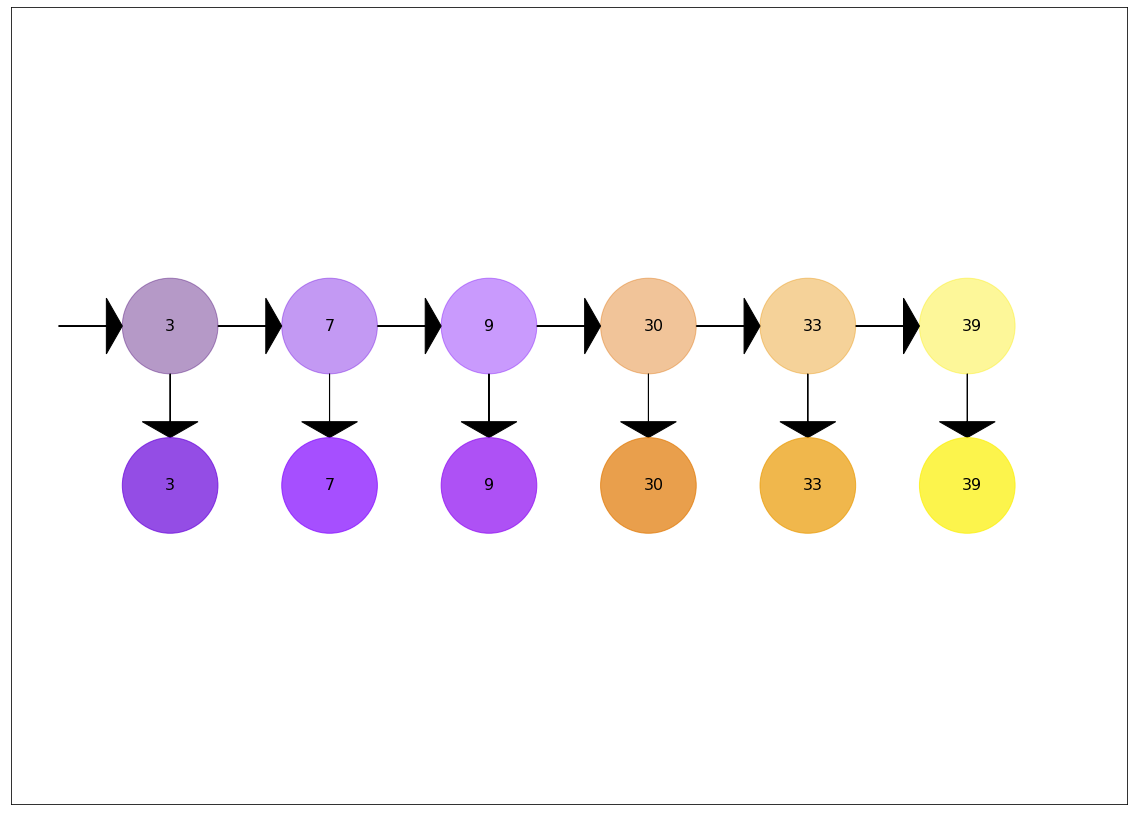

['++-+', '++0-', '+-++', '-+-+', '-+0+', '---+']


In [45]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating rejections HMM

In [46]:
u_seqs = u_study_seqs

u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
print(u_seqs)
[list(map(num_to_QTC_C, seq)) for seq in u_seqs]

# Create HMM using uniform parameters as a baseline to compare against pass-by
A = np.ones((N_nodes, N_nodes))
print(A.shape)

if rejections_trained:
    # Give frequency based probs to e.g. transitions
    for seq in u_seqs:
        for i in range(0, len(seq) - 1):
            print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
if rejections_trained:
    for seq in u_seqs:
        Pi[seq[0]] += rejection_init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())


uniform_HMM = hmms.DtHMM(A, B, Pi)

# Check uniform_HMM params
A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
print("A:\n", A_uniform)
for row in A_uniform:
    print(row.sum())
print("B:\n", B_uniform)
for row in B_uniform:
    print(row.sum())
print("Pi:\n", Pi_uniform)
print(Pi_uniform.sum())

[[39, 42, 45, 36, 45, 36, 45, 54, 0], [30, 39, 41, 48, 39, 41, 39, 41, 39, 41, 39, 41, 48, 40, 41, 40, 68, 66, 75, 66, 75, 66, 75], [75], [28], [30, 48, 39, 48, 41, 39, 48, 39, 41, 39, 41, 40, 41, 67, 68, 67, 68, 75, 66, 75], [31, 39, 42, 36, 27, 45, 27, 36, 0], [40, 41, 40, 41, 40, 41, 40, 41, 30], [39, 42, 36, 27, 36, 0], [30], [39, 48, 39, 48, 39, 48, 30], [40, 41, 39, 41, 40, 39, 40, 13, 4, 7, 1]]
(81, 81)
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
9
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]

rejections HMM:


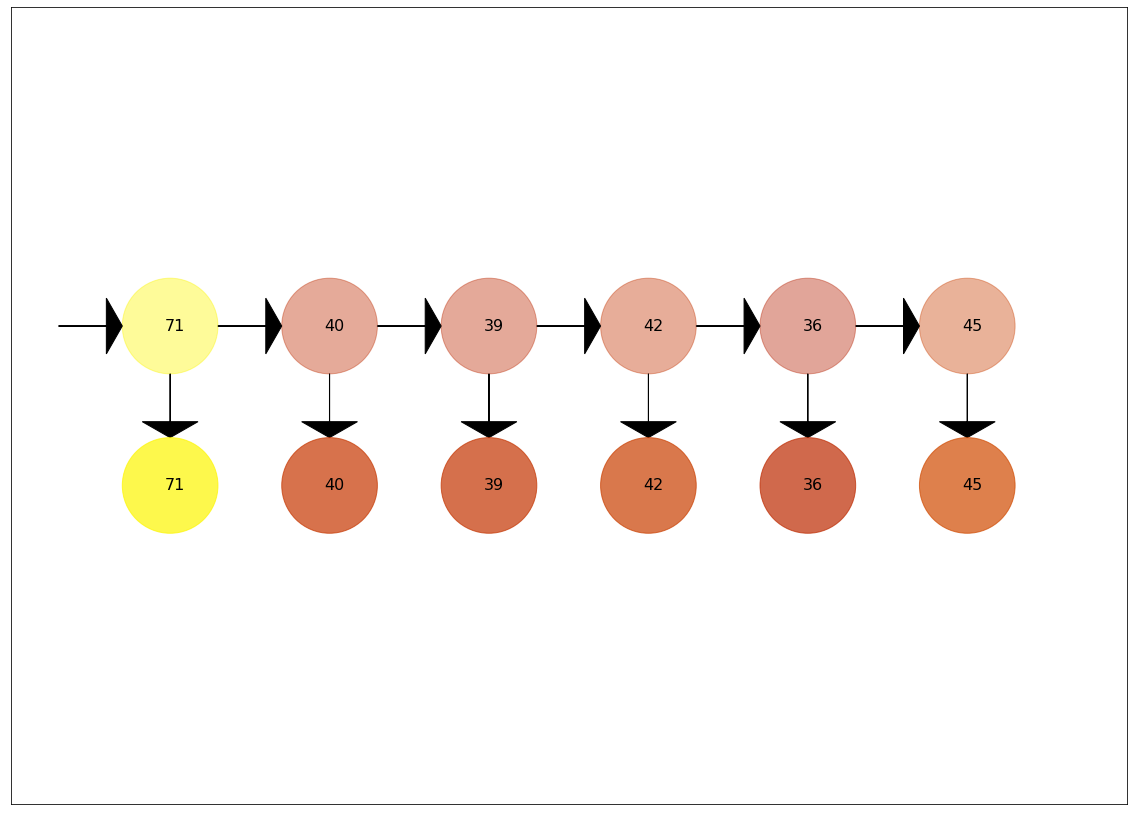

['0-00', '----', '---+', '--0+', '--++', '-0++']


In [47]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = uniform_HMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("rejections HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Classifying HRI situation of QTC<sub>C</sub> sequences generated by rejections HMM

In [48]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
s_seqs, e_seqs = uniform_HMM.generate_data((len(pass_by_l_seqs), len(pass_by_l_seqs[0])))
e_seqs

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-391.7559533480326
The probability of the dataset being generated by the pass-by left model is: 7.287040918522136e-171 .
-419.6695870134356
The probability of the dataset being generated by the pass-by right model is: 5.493057402777639e-183 .
-306.28900380413256
The probability of the dataset being generated by the rejection model is: 9.558192661721845e-134 .
-384.4235204126909
The probability of the dataset being generated by the robot overtaking left model is: 1.1142595652869879e-167 .
-420.56157399138493
The probability of the dataset being generated by the robot overtaking right model is: 2.251277935973748e-183 .
-410.5410909029904
The probability of the dataset being generated by the path-crossing model is: 5.061387944120559e-179 .
Classified as rejection


## Classifying HRI situation of example pass-by left QTC<sub>C</sub> sequences

In [49]:
pass_by_l_seqs = [np.array(seq) for seq in pass_by_l_seqs]

In [50]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_l_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-81.1735434446013
The probability of the dataset being generated by the pass-by left model is: 5.5818479934376996e-36 .
-476.974219241025
The probability of the dataset being generated by the pass-by right model is: 7.124076485876342e-208 .
-376.0016259976215
The probability of the dataset being generated by the rejection model is: 5.064873962595557e-164 .
-474.8601605797869
The probability of the dataset being generated by the robot overtaking left model is: 5.9000077825115e-207 .
-481.38371350661316
The probability of the dataset being generated by the robot overtaking right model is: 8.663822497578897e-210 .
-493.92813555947555
The probability of the dataset being generated by the path-crossing model is: 3.0884193853044757e-215 .
Classified as pass-by left


## Classifying HRI situation of example pass-by right QTC<sub>C</sub> sequences

In [51]:
pass_by_r_seqs = [np.array(seq) for seq in pass_by_r_seqs]

In [52]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_r_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-329.8669729882534
The probability of the dataset being generated by the pass-by left model is: 5.502928487942686e-144 .
-57.207894723862296
The probability of the dataset being generated by the pass-by right model is: 1.4286537981604478e-25 .
-209.7293908694906
The probability of the dataset being generated by the rejection model is: 8.235365002492829e-92 .
-398.2026265335535
The probability of the dataset being generated by the robot overtaking left model is: 1.1555709541354017e-173 .
-382.2159476549089
The probability of the dataset being generated by the robot overtaking right model is: 1.0132649917286788e-166 .
-291.6364045650691
The probability of the dataset being generated by the path-crossing model is: 2.207591815540183e-127 .
Classified as pass-by right


## Classifying HRI situation of example robot overtaking left QTC<sub>C</sub> sequences

In [53]:
rotl_seqs = [np.array(seq) for seq in rotl_seqs]

In [54]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotl_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-844.504273272758
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-926.2719868458348
The probability of the dataset being generated by the pass-by right model is: 0.0 .
-513.9530855430598
The probability of the dataset being generated by the rejection model is: 6.208847479176879e-224 .
-178.3147795322842
The probability of the dataset being generated by the robot overtaking left model is: 3.6213892439037274e-78 .
-890.5786479022993
The probability of the dataset being generated by the robot overtaking right model is: 0.0 .
-579.2556749641735
The probability of the dataset being generated by the path-crossing model is: 2.706803640513262e-252 .
Classified as robot overtaking left


## Classifying HRI situation of example robot overtaking right QTC<sub>C</sub> sequences

In [55]:
rotr_seqs = [np.array(seq) for seq in rotr_seqs]

In [56]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotr_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-743.6177411134234
The probability of the dataset being generated by the pass-by left model is: 1e-323 .
-765.78860556359
The probability of the dataset being generated by the pass-by right model is: 0.0 .
-731.2258411698327
The probability of the dataset being generated by the rejection model is: 2.708023e-318 .
-744.6191818661459
The probability of the dataset being generated by the robot overtaking left model is: 5e-324 .
-124.33374737971803
The probability of the dataset being generated by the robot overtaking right model is: 1.0058647727940642e-54 .
-760.6083650754329
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as robot overtaking right


## Classifying HRI situation of example path-crossing QTC<sub>C</sub> sequences

In [57]:
pc_seqs = [np.array(seq) for seq in pc_seqs]

In [58]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pc_seqs)

print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[41 76  5 59 39 48 36  0]
 [67 68 75 66 75 66 75 66]
 [60 72 55 53 26  3 60 18]
 [29  4  7 18 73 31 39 48]
 [79 54 49 30 39 48 39 48]
 [48 40 68 36 27 45 27 45]
 [43 61 10 78 47 63 52 47]
 [67 68 75 55  4  6  6  0]
 [80 35 80 41 40 26 70 54]
 [38 30 78 24 16  3 24 68]
 [39 48 39 48 39 43 48 39]]
-762.1402700759759
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-734.4626701529503
The probability of the dataset being generated by the pass-by right model is: 1.0639e-319 .
-704.2655351419193
The probability of the dataset being generated by the rejection model is: 1.384727423673745e-306 .
-678.3723895360049
The probability of the dataset being generated by the robot overtaking left model is: 2.4356481388585314e-295 .
-755.5766889364644
The probability of the dataset being generated by the robot overtaking right model is: 0.0 .
-148.69368553163446
The probability of the dataset being generated by the path-crossing model is: 2.649432624145428e-65 .
Classi

## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences

In [59]:
# Get hidden states and emissions sequences from observed sequences
sequence_no = 5
symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_lab_seqs[i]] for i in range(len(u_lab_seqs))]
e_seqs = np.array([symbol_seqs[sequence_no]])

print(list(map(num_to_QTC_C, s_seqs[0])))

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

['---0', '00--', '++-0', '0+-0', '---+', '-0-+', '--++', '++++']
-6.555911085133749
The probability of the dataset being generated by the pass-by left model is: 0.001421686998881467 .
-6.555911085133749
The probability of the dataset being generated by the pass-by right model is: 0.001421686998881467 .
-4.515021402654457
The probability of the dataset being generated by the rejection model is: 0.01094337090713901 .
-6.555911085133749
The probability of the dataset being generated by the robot overtaking left model is: 0.001421686998881467 .
-6.504893649110495
The probability of the dataset being generated by the robot overtaking right model is: 0.001496099861810624 .
-6.856241247160866
The probability of the dataset being generated by the path-crossing model is: 0.0010528639597873902 .
Classified as rejection


## Holdout Validation of Classifying HRSI situation of all experimenter QTC<sub>C</sub> sequences

In [60]:
overall_accs = []
rotl_accs = []
rotr_accs = []
pbl_accs = []
pbr_accs = []
pc_accs = []
u_accs = []

y_true = []
y_pred = []

rotl_lab_seqs_train = np.array(rotl_study_seqs)
rotl_lab_seqs_val = np.array(rotl_lab_seqs)

rotr_lab_seqs_train = np.array(rotr_study_seqs)
rotr_lab_seqs_val = np.array(rotr_lab_seqs)

pb_l_lab_seqs_train = np.array(pb_l_study_seqs)
pb_l_lab_seqs_val = np.array(pb_l_lab_seqs)

pb_r_lab_seqs_train = np.array(pb_r_study_seqs)
pb_r_lab_seqs_val = np.array(pb_r_lab_seqs)

pc_lab_seqs_train = np.array(pc_study_seqs)
pc_lab_seqs_val = np.array(pc_lab_seqs)

u_lab_seqs_train = np.array(u_study_seqs)
u_lab_seqs_val =  np.array(u_lab_seqs)

# Get correct count and accuracy of pass-by left classifications
pb_l_correct = 0
for pb_l_seq in pb_l_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_l_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 0
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        pb_l_correct += 1

    pb_l_acc = pb_l_correct/len(pb_l_lab_seqs_val)*100
print("Pass-by left classifications are " + str(pb_l_acc) + "% accurate\n" )

# Get correct count and accuracy of pass-by classifications
pb_r_correct = 0
for pb_r_seq in pb_r_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_r_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_r)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_r, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 1
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        pb_r_correct += 1

    pb_r_acc = (pb_r_correct/len(pb_r_lab_seqs_val))*100
print("Pass-by right classifications are " + str(pb_r_acc) + "% accurate\n" )

# Get correct count and accuracy of robot overtaking left classifications
rotl_correct = 0
for rotl_seq in rotl_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotl_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_r)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_r, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 2
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        rotl_correct += 1

    rotl_acc = (rotl_correct/len(rotl_lab_seqs_val))*100
print("Robot overtaking left classifications are " + str(rotl_acc) + "% accurate\n" )

# Get correct count and accuracy of robot overtaking right classifications
rotr_correct = 0
for rotr_seq in rotr_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotr_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_r)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_r, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 3
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        rotr_correct += 1

    rotr_acc = (rotr_correct/len(rotr_lab_seqs_val))*100
print("Robot overtaking right classifications are " + str(rotr_acc) + "% accurate\n" )

# Get correct count and accuracy of path-crossing classifications
pcs_correct = 0
for pc_seq in pc_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pc_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_r)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_r, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 4
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        pcs_correct += 1

    pc_acc = (pcs_correct/len(pc_lab_seqs_val))*100
print("Path-crossing classifications are " + str(pc_acc) + "% accurate\n" )

# Get correct count and accuracy of rejections
us_correct = 0
for u_seq in u_lab_seqs_val:
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
    e_seqs = np.array(symbol_seqs)

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_r)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_r, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

    classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id])

    correct_class_id = 5
    y_true.append(correct_class_id)
    y_pred.append(class_id)
    if class_id == correct_class_id:
        us_correct += 1

# Rejections recall
rTPs = us_correct
rFNs = len(u_lab_seqs_val) - us_correct
# rFPs = 0 # As accuracy in all other classes is 100%
recall = rTPs / (rTPs + rFNs)
# precision = rTPs / (rTPs + rFPs)

u_acc = us_correct/len(u_lab_seqs_val)*100

print("Rejection classifications are " + str(u_acc) + "% accurate\n" )

#     print("Rejections FN rate: " + str((rFNs/len(u_lab_seqs_val)*100)) + "%")
#     print("Rejections accuracy: " + str(u_acc) + "%" )
#     print("Rejection recall:", str(recall * 100) + "%")
# print("Rejection precision:", str(precision * 100) + "%")

total = len(pb_l_lab_seqs_val) + len(pb_r_lab_seqs_val) + len(rotl_lab_seqs_val) + len(rotl_lab_seqs_val) + len(pc_lab_seqs_val)
total_correct = pb_l_correct + pb_r_correct + rotr_correct + rotl_correct + pcs_correct

overall_acc = (total_correct/total)*100
print("\nOverall accuracy (excluding rejections): " + str(overall_acc) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_acc)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_acc)) + "%")
print("Pass-by left TPR: " + str(np.mean(pb_l_acc)) + "%")
print("Pass-by right TPR: " + str(np.mean(pb_r_acc)) + "%")
print("Path-crossing TPR: " + str(np.mean(pc_acc)) + "%")
print("Rejection TPR: " + str(np.mean(u_acc)) + "%\n")

overall_accs.append(overall_acc)
rotl_accs.append(rotl_acc)
rotr_accs.append(rotr_acc)
pbl_accs.append(pb_l_acc)
pbr_accs.append(pb_r_acc)
pc_accs.append(pc_acc)
u_accs.append(u_acc)

Classified as pass-by left
Classified as pass-by left
Classified as pass-by right
Classified as pass-by right
Classified as pass-by left
Classified as pass-by left
Classified as pass-by right
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by right
Classified as pass-by left
Classified as pass-by right
Classified as pass-by right
Classified as rejection
Classified as pass-by right
Classified as pass-by right
Classified as rejection
Classified as pass-by right
Classified as rejection
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Pass-by left classifications are 57.14285714285714% 

Classified as pass-by right
Classified as pass-by right
Classified as rejection
Classified as rejection
Classified as rejection
Classified as pass-by right
Classified as rejection
Classified as pass-by right
Classified as path-crossing
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as pass-by left
Classified as robot overtaking left
Classified as robot overtaking left
Classified as robot overtaking left
Classified as robot overtaking left
Classified as robot overtaking left
Classified as robot overtaking right
Classified as rejection
Classified as robot overtaking right
Classified as robot overtaking right
Classified as robot overtaking right
Classified as rejection
Classified as rejection
Classified as pass-by right
Classified as rejection
Classified as rejection
Classified as pass-by right
Classified as rejection
Classified as pass-by right
Classified as rejection
Classified as

In [61]:
len(pc_lab_seqs_val)

70

In [62]:
print("K-fold CV results:")
print("Overall accuracy (excluding rejections): " + str(np.mean(overall_accs)) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_accs)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_accs)) + "%")
print("Pass-by left TPR: " + str(np.mean(pbl_accs)) + "%")
print("Pass-by right TPR: " + str(np.mean(pbr_accs)) + "%")
print("Path-crossing TPR: " + str(np.mean(pc_accs)) + "%")
print("Rejection TPR: " + str(np.mean(u_accs)) + "%")

K-fold CV results:
Overall accuracy (excluding rejections): 82.38095238095238%
Robot overtaking left TPR: 88.57142857142857%
Robot overtaking right TPR: 97.14285714285714%
Pass-by left TPR: 57.14285714285714%
Pass-by right TPR: 51.42857142857142%
Path-crossing TPR: 100.0%
Rejection TPR: 54.285714285714285%


In [63]:
cm = confusion_matrix(y_true, y_pred)

In [64]:
cm

array([[20, 12,  0,  0,  0,  3],
       [16, 18,  0,  0,  0,  1],
       [ 2,  0, 31,  0,  0,  2],
       [ 0,  0,  0, 34,  1,  0],
       [ 0,  0,  0,  0, 70,  0],
       [19, 13,  5,  5,  6, 57]])

In [65]:
df_cm = pd.DataFrame(cm, range(6), range(6))
df_cm.columns = classes
df_cm.index = classes
df_cm

,pass-by left,pass-by right,robot overtaking left,robot overtaking right,path-crossing,rejection
pass-by left,20,12,0,0,0,3
pass-by right,16,18,0,0,0,1
robot overtaking left,2,0,31,0,0,2
robot overtaking right,0,0,0,34,1,0
path-crossing,0,0,0,0,70,0
rejection,19,13,5,5,6,57


/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:167: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:170: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:171: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = Fa

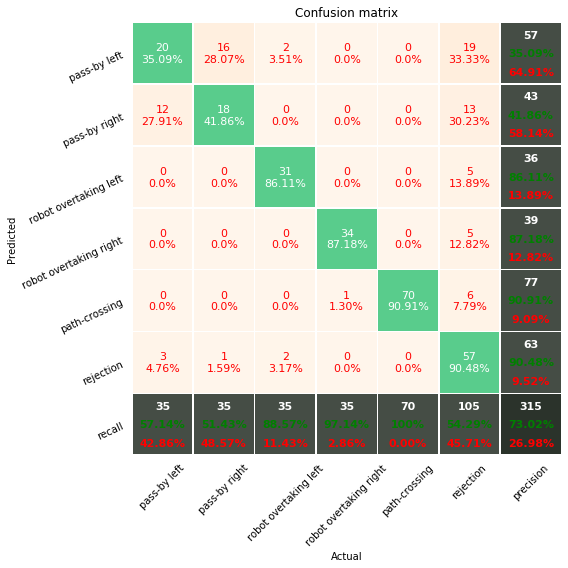

In [66]:
# From MATLAB plotconfusion docs (which inspired this confusion matrix plotting module):
# The column on the far right of the plot shows the percentages of all the examples predicted to belong to each
# class that are correctly and incorrectly classified. These metrics are often called the precision 
# (or positive predictive value) and false discovery rate, respectively. The row at the bottom of the plot shows
# the percentages of all the examples belonging to each class that are correctly and incorrectly classified. 
# These metrics are often called the recall (or true positive rate) and false negative rate, respectively.
# The cell in the bottom right of the plot shows the overall accuracy.
pretty_plot_confusion_matrix(df_cm, show_null_values=2)